# Getting started with CUDA

Video lecture: [Getting Started with CUDA for Python Programmers](https://www.youtube.com/watch?v=nOxKexn3iBo&t=814s)

### Setup

In [1]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

In [2]:
!nvidia-smi

Sat Feb 17 21:18:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:01:00.0 Off |                  N/A |
|  0%   24C    P8               6W / 280W |     47MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# # uncomment this cell to download the image we are going to use in the rest of the notebook
# !wget https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Cute_dog.jpg/1600px-Cute_dog.jpg -O ../../imgs/puppy.jpg

In [4]:
img = io.read_image("../../imgs/puppy.jpg")
print(img.shape)
img[:2, :3, :4]

torch.Size([3, 1066, 1600])


tensor([[[117, 119, 117, 113],
         [119, 129, 129, 113],
         [130, 126, 122, 115]],

        [[ 83,  85,  85,  80],
         [ 85,  97,  97,  82],
         [ 98,  93,  89,  83]]], dtype=torch.uint8)

In [5]:
def show_img(x, figsize=(4, 3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis("off")
    if len(x.shape) == 3:
        x = x.permute(1, 2, 0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [6]:
img2 = tvf.resize(img, 150, antialias=True)
ch, h, w = img2.shape
ch, h, w, h * w

(3, 150, 225, 33750)

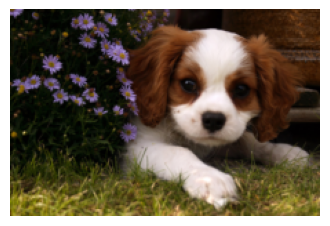

In [7]:
show_img(img2)

## RGB -> Grey

### Basic Python

In [8]:
def rgb2grey_py(x):
    c, h, w = x.shape
    n = h * w  # number of pixels in each channel
    x = x.flatten()
    res = torch.empty(
        n, dtype=x.dtype, device=x.device
    )  # one channel only, since the output image will be in grayscale
    for i in range(n):
        res[i] = 0.2989 * x[i] + 0.5870 * x[i + n] + 0.1140 * x[i + 2 * n]
    return res.view(h, w)

In [9]:
%%time
img_g = rgb2grey_py(img2)

CPU times: user 962 ms, sys: 0 ns, total: 962 ms
Wall time: 961 ms


In [10]:
img2.flatten()

tensor([100, 102, 106,  ...,  35,  33,  39], dtype=torch.uint8)

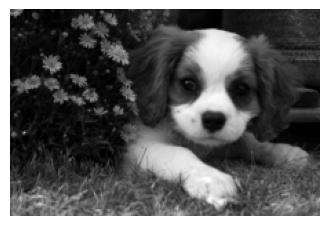

In [11]:
show_img(img_g, cmap="gray")

# Python Kernel

In [12]:
# this is not executed in parallel, but conceptually we are simulating the CUDA API1
def run_kernel(f, times, *args):
    for i in range(times):
        f(i, *args)

NOTE: A kernel can not return anything. It can only change contents of things passed to it. 

In [13]:
def rgb2grey_k(i, x, out, n):
    out[i] = 0.2989 * x[i] + 0.5870 * x[i + n] + 0.1140 * x[i + 2 * n]

In [14]:
def rgb2grey_pyk(x):
    c, h, w = x.shape
    n = h * w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    run_kernel(rgb2grey_k, h * w, x, res, n)
    return res.view(h, w)

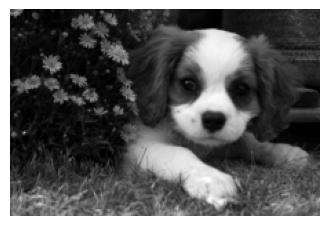

In [15]:
img_g = rgb2grey_pyk(img2)
show_img(img_g, cmap="gray")

# Python Block Kernel

1. **Streaming Multiprocessors (SMs)**: In NVIDIA GPUs, SMs are the fundamental units of execution. Each SM can execute multiple threads concurrently.
2. **Thread Blocks**: A thread block is a group of threads that can cooperate among themselves through shared memory and synchronization. All threads in a block are executed on the same SM. This means they can share resources such as shared memory and can synchronize their execution with each other.
3. **Shared Memory**: Shared memory is a small memory space on the GPU that is shared among the threads in a block. It is much faster than global memory (the main GPU memory), but it is also limited in size. Threads in the same block can use shared memory to share data with each other efficiently.

* The RTX 3090, based on the Ampere architecture, has 82 SMs.
* Each SM in GA10x GPUs contain 128 CUDA Cores, four third-generation Tensor Cores, a 256 KB Register File, and 128 KB of L1/Shared Memory
* In CUDA, all threads in a block have the potential to run concurrently. However, the actual concurrency depends on the number of CUDA cores per SM and the resources required by the threads.

In [16]:
128 * 82  # total CUDA cores in a RTX 3090

10496